In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import glob
import re
import os
from scipy.stats import kde, f_oneway
from bisect import bisect_left
from mpl_toolkits.mplot3d import Axes3D

# reading data

In [2]:
sequences_dict = {}
with open("sequences.txt") as open_file:
    for line in open_file:
        split_line = line.split()
        # headerline
        if "Clone" in line:
            # protein, familie, sequence, interaction strength
            header = [split_line[2], split_line[3], " ".join(split_line[4:7]), " ".join(split_line[7:])]
        # if there is still anything in the line after stripping whitespaces away, treat it as data
        elif line.strip():
            items = []
            for item in split_line[1:4]:  # protein, family and sequence
                items.append(item)
            
            # interaction propensity
            items.append(" ".join(split_line[4:]))
            
            # protein: items
            sequences_dict[int(split_line[0])] = items
            
sequences_df = pd.DataFrame.from_dict(sequences_dict, "index")
sequences_df.columns = header
sequences_df = sequences_df.sort_index()
sequences_df.head()

Protein         Family               TM domain sequence  \
-1  GpA-WT  StrongControl             RASLIIFGVMAGVIGTILIN   
 1    DDR2            DDR      RASILIGCLVAIIFILLAIIVIILGIL   
 2    DDR1            DDR      RASILIGCLVAIILLLLLIIALMLGIL   
 3     LTK            ALK  RASLVLMVAVVATSTLSLLMVCGVLILVGIL   
 4    TIE1            TIE   RASLILAVVGSVSATCLTILAALLTLVGIL   

   Interaction propensity  
-1            1.00 ± 0.08  
 1            2.28 ± 0.45  
 2            1.69 ± 0.40  
 3            1.63 ± 0.14  
 4            1.31 ± 0.15

### sequence

In [3]:
def get_sequence(protein):
    for i, p in enumerate(sequences_df.iloc[:, 0]):  # for every row the protein
        if p == protein:
            return sequences_df.iloc[i, 2]  # the sequence of the protein at index i.

def get_interaction_strength(protein):
    for i, p in enumerate(sequences_df.iloc[:, 0]):  # for every row the protein
        if p == protein:
            return sequences_df.iloc[i, 3]  # the sequence of the protein at index i.

def get_seq_list(sequence):
    sequence_list = list()
    for i in range(2):
        for aa in sequence:
            for y in range(3):
                sequence_list.append(".".join([aa, str(i + 1)]))

    return sequence_list

### energy

In [4]:
def get_energy(file):
    p = "(.*)coords.dat"
    m = re.match(p, file)
    path = "".join([m.groups()[0], "energy.dat"])
    energy = pd.read_table(path, sep=" ", index_col=False)
    # putting the time as rownames
    energy = energy.rename(mapper=energy.iloc[:,0], axis="index").iloc[:, 1:11]
    return energy

### coordinates

In [5]:
def write_file(file):
    p = "(.*)coords.dat"
    m = re.match(p, file)
    path = "".join([m.groups()[0], "temp.txt"])
    with open(file) as open_file:
        with open(path, "w") as temp:
            for line in open_file:
                temp.write(";".join(line.split()))
                temp.write("\n")
    os.rename(path, file)
    
def get_coords(file, sequence_list):
    coordinates = pd.read_table(file, sep=";")
    # putting the time as rownames
    coordinates = coordinates.rename(mapper=coordinates.iloc[:,0], axis="index").iloc[:, 1:len(coordinates.columns)]
    # adding sequence list to coordinates with rowlabel 0
    coordinates.loc[-1] = sequence_list
    # sort so that sequence will be on top
    coordinates = coordinates.sort_index()
    return coordinates

# introductory data analysis
## creating distence score matrix

In [6]:
def get_distance_score(coordinates, sequence):
    length = len(sequence)*3
    indexes = [i for i in range(len(sequence))]
    # every letter of the sequence with the number of it's position behind it
    columns = [".".join([a, str(i+1)]) for a, i in zip(list(sequence), indexes)]
    columns.append("total")

    # create empty dataframe with time from coordinates on the rows and created column names as the columns.
    distence_df = pd.DataFrame(index=coordinates.index[1:], columns=columns)
    for idx in range(1, len(coordinates)):
        scores = []
        for i in range(0, int(len(coordinates.iloc[1, :])/2), 3):
            first_coordinates = coordinates.iloc[idx, i:i+3].values
            second_coordinates = coordinates.iloc[idx, i+length:i+length+3].values
            score = 0
            for a, b in zip(first_coordinates, second_coordinates):
                difference = abs(a-b)
                if difference < 3:
                    score -= 15
                elif 3 < difference < 7:
                    score -= 6
                else:
                    score -= 0
            scores.append(score)
        total = sum(scores)
        scores.append(total)
        distence_df.iloc[idx-1, :] = scores
    return distence_df

## comparison of the data

In [7]:
def comparison_plot(distence_df, energy):
    plt.bar(distence_df.index[0:len(distence_df):10], distence_df.iloc[0:len(distence_df):10, -1], width=100000)
    plt.plot(energy.iloc[0:len(energy):10, 1], "m")
    plt.plot(energy.iloc[0:len(energy):10, 2], "k")
    plt.plot(energy.iloc[0:len(energy):10, 5], "y")
    plt.ylim(ymin=-1000)
    plt.legend(["AB", "AM", "BM", "distance score"], loc=0)
    plt.xlabel("time (picoseconds)")
    plt.ylabel("distance score (a.u.) and free energy")
    plt.title("comparison of distance score and free energy between two alfa-helices")
    plt.show()
    print("Figure 1: energy signatures compared to distence scores of the helices.\n"\
    "In this figure, the blue bars represent the distence between the two helices at that specific time. The lower the distence score, the closer they are to eachother.\n"\
    "The lines represent the free energy in different situations: purple represents the free energy between the two alfahelices, yellow the free energy between helix 2 and the membrane\nand black the free energy between helix one and the membrane.\nThe lower these are, the more interaction between the specific elements there is.\n\n")

## finding interesting timesamples with strong interactions

In [8]:
def takeClosest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.
    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return 1
    if pos == len(myList):
        return len(myList)
    
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
       return pos+1
    else:
       return pos

def find_interesting(energy, coordinates):
    energy_sortedAB = energy.sort_values("AB")
    strongest_energy = []
    lowest_energy = 0
    for time in energy_sortedAB.index[0:int(len(energy)*0.05)]:
        pos = takeClosest(coordinates.index[1:], time)
        strongest_energy.append(pos)
        lowest_energy = energy.loc[time, "AB"]
    strongest_energy.sort()
    
    # create dataframe from list
    strongest_dict = {-1: coordinates.iloc[0, :]}
    for i in strongest_energy:
        strongest_dict[coordinates.index[i]] = coordinates.iloc[i, :]
    
    interesting_df = pd.DataFrame.from_dict(strongest_dict, "index")
    return interesting_df, lowest_energy

# finding fingerprints of interactions

## comparing stance
### 3d plots

In [9]:
def plot_helices_3d(interesting_df, sequence):
    xs = [i for i in range(0, len(interesting_df.columns), 3)]
    ys = [i for i in range(1, len(interesting_df.columns), 3)]
    zs = [i for i in range(2, len(interesting_df.columns), 3)]

    # for every timepoint, plot the stance of the helices
    for time in range(1, len(interesting_df.index)):
        x1 = list(interesting_df.iloc[time, xs[:int(len(xs)/2)]])
        x2 = list(interesting_df.iloc[time, xs[int(len(xs)/2):]])
        y1 = list(interesting_df.iloc[time, ys[:int(len(ys)/2)]])
        y2 = list(interesting_df.iloc[time, ys[int(len(ys)/2):]])
        z1 = list(interesting_df.iloc[time, zs[:int(len(zs)/2)]])
        z2 = list(interesting_df.iloc[time, zs[int(len(zs)/2):]])

        # plotting stance
        fig = plt.figure()
        # creating a 3d plot
        ax = fig.add_subplot(111, projection='3d')
        ax.plot(x1, y1, z1, label="helix 1")
        ax.plot(x2, y2, z2, label="helix 2")

        # setting ax-labels
        ax.set_xlabel("$X$")
        ax.set_ylabel("$Y$")
        ax.set_zlabel("$Z$")

        # adding a legend
        ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=4, borderaxespad=0.)

        # adding sequence letters as datapoint labels
        # helix 1
        for i, cords in enumerate(zip(x1, y1, z1)):
            x = cords[0]
            y = cords[1]
            z = cords[2]
            label = sequence[i]
            # adding the label
            ax.text(x, y, z+1, label, None)

        # helix 2
        for i, cords in enumerate(zip(x2, y2, z2)):
            x = cords[0]
            y = cords[1]
            z = cords[2]
            label = sequence[i]
            # adding the label
            ax.text(x, y, z+1, label, None, color="m")

        # adding a title to the plot
        plt.title("helix orientations for timepoint {}".format(interesting_df.index[time]))
        plt.show()

Figure 2: stance of the two helices on the timepoints with the strongest 5% binding energy between the two helices. The letters represent the aminoacids on that point in the helices. The 'floor' of the plot represents the upside of the membrane, on which the protein domain is stationed. The timepoints mentioned in the plot titles are timepoints in picoseconds since the start of the simulation.

### helix 2 orientation compared to helix 1

In [10]:
def orientation_fabrication(coordinates, interesting_df, len_seq):
    means_dict = {}
    # interesting range
    min_inter = [0, 0, 0]
    max_inter = [0, 0, 0]

    # non-interesting range
    min_ninter = [0, 0, 0]
    max_ninter = [0, 0, 0]

    for i in range(len(coordinates)-1):
        BB = coordinates.iloc[i+1, :].values.reshape((-1, 3)).astype('float32')

        centered = BB - BB[3:9, :].mean(axis=0)

        # Z axis
        p = np.dot((1, 2, 2, 2, 1), centered[3:8, :])/8
        q = np.dot((1, 2, 2, 2, 1), centered[4:9, :])/8
        zaxis = p-q
        zaxis /= np.sqrt((zaxis**2).sum())

        # Y axis
        yaxis = np.cross(zaxis, centered[3,:])
        yaxis /= np.sqrt((yaxis**2).sum())

        # X axis
        xaxis = np.cross(yaxis, zaxis)

        rotation = np.linalg.inv((xaxis, yaxis, zaxis))
        oriented = np.dot(centered, rotation)
        
        # analyze oriented
        means = [0, 0, 0]
        for y, a in enumerate(oriented.T):
            if coordinates.index[i+1] in interesting_df.index:
                if min_inter[y] > min(a[3+len_seq:8+len_seq]):
                    min_inter[y] = min(a[3+len_seq:8+len_seq])
                if max_inter[y] < max(a[3+len_seq:8+len_seq]):
                    max_inter[y] = max(a[3+len_seq:8+len_seq])
            else:
                if min_ninter[y] > min(a[3+len_seq:8+len_seq]):
                    min_ninter[y] = min(a[3+len_seq:8+len_seq])
                if max_ninter[y] < max(a[3+len_seq:8+len_seq]):
                    max_ninter[y] = max(a[3+len_seq:8+len_seq])
            means[y] = a[3+len_seq:8+len_seq].mean()

        means_dict[coordinates.index[i+1]] = means

    means_df = pd.DataFrame.from_dict(means_dict, "index")
    means_df.columns = ["X", "Y", "Z"]
    means_df = means_df.sort_index()
    
    return [means_df, [min_inter, max_inter], [min_ninter, max_ninter]]


def find_result_range(means):
    x_range = 0
    y_range = 0
    z_range = 0
    x_threshold = (max(means.T.iloc[0, :].values) - min(means.T.iloc[0, :].values))*0.05
    y_threshold = (max(means.T.iloc[1, :].values) - min(means.T.iloc[1, :].values))*0.05
    z_threshold = (max(means.T.iloc[2, :].values) - min(means.T.iloc[2, :].values))*0.05
    
    for i in range(len(means)):
        x = abs(means.iloc[-(i+1), 0])
        y = abs(means.iloc[-(i+1), 1])
        z = abs(means.iloc[-(i+1), 2])
        
        x_dif = abs(means.iloc[-1, 0])-x
        y_dif = abs(means.iloc[-1, 1])-y
        z_dif = abs(means.iloc[-1, 2])-z
        
        if x_dif > x_threshold or y_dif > y_threshold or z_dif > z_threshold:
            return i

In [11]:
def visualize_range(inter, ninter):
    # visualizing analysis results
    print("Axis | strong interactions | weaker interactions\n",
      "X   |", round(inter[0][0], 2), "till", round(inter[1][0], 2), "|",
      round(ninter[0][0], 2), "till", round(ninter[1][0], 2), "\n",
      "Y   |", round(inter[0][1], 2), "till", round(inter[1][1], 2), "|",
      round(ninter[0][1], 2), "till", round(ninter[1][1], 2), "\n",
      "Z   |", round(inter[0][2], 2), "till", round(inter[1][2], 2), "|",
      round(ninter[0][2], 2), "till", round(ninter[1][2], 2),"\n",
      "The range in which the X, Y and Z coordinates of helix 2 residues 3 till 7 lay\n",
      "compared to helix 1 residues 3 till 7")

def scatterplot_orientation(means_df, lowest_energy, interesting_df):
    # plotting means
    fig = plt.figure()
    # creating a 3d plot
    ax = fig.add_subplot(111, projection='3d')

    # plotting data
    for i in range(len(means_df)):
        x = means_df.iloc[i, 0]
        y = means_df.iloc[i, 1]
        z = means_df.iloc[i, 2]

        if means_df.index[i] in interesting_df.index:
            strong = ax.scatter(x, y, z, c="m", s=15)
        else:
            weaker = ax.scatter(x, y, z, c="b", s=1)

    # setting ax-labels
    ax.set_xlabel("$X$")
    ax.set_ylabel("$Y$")
    ax.set_zlabel("$Z$")

    # adding a legend
    ax.legend([strong, weaker], 
              ["strong interactions (free energy lower than {})".format(round(lowest_energy, 2)), 
               "weaker interaction"], 
              bbox_to_anchor=(0., 1.08, 1., .102), loc=4, 
              borderaxespad=0.)

    # adding a title to the plot
    plt.title("average orientation of residues 3 till 7 of helix 2\n" \
              "compared to orientation of resiues 3 till 7 of helix 1.")
    plt.show()

Figure 3: average orientation of residues 3 till 7 of helix 2, compared to helix 1 residues 3 till 7.
The Z-axis was made in such a way that it would go straight through helix 1.
The Y-axis goes from before (negative values) helix 1 to after (positive values) helix 1 and the X-axis from left (negative values) to right (positive values).

### density analysis

In [12]:
def gaussian_kde(means, interesting_list, result_range=100, plot=True, contour=True):
    # Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
    interesting = []
    
    for time in interesting_list:
        if time in means.index[-result_range:]:
            interesting.append(time)
    oriented = means.iloc[-result_range:, :].values.astype("float32")
    x, y, z = oriented.T
    
    if plot:
        nbins = 20
        X, Y = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
        k = kde.gaussian_kde(oriented.T[:2])
        positions = np.vstack([X.flatten(), Y.flatten()])
        Z = np.reshape(k(positions), X.shape)
    
    if len(interesting) > 2:
        orientedi = means.loc[interesting, :].values.astype("float32")
        xi, yi, zi = orientedi.T
        
        if plot:
            ki = kde.gaussian_kde(orientedi.T[:2])
            Xi, Yi = np.mgrid[xi.min():xi.max():nbins*1j, yi.min():yi.max():nbins*1j]
            positionsi = np.vstack([Xi.flatten(), Yi.flatten()])
            Zi = np.reshape(ki(positionsi), Xi.shape)

            fig, ax = plt.subplots(ncols=2)
            ax[0].set_title('Gaussian KDE')
            ax[0].set_ylabel("Y")
            ax[0].set_xlabel("X")
            ax[1].set_title('Gaussian KDE interesting')
            ax[1].set_xlabel("X")
            plot = ax[0].pcolormesh(X, Y, Z, shading='gouraud')
            ploti = ax[1].pcolormesh(Xi, Yi, Zi, shading='gouraud')
            if contour:
                ax[0].contour(X, Y, Z, colors="black")
            ax[1].contour(Xi, Yi, Zi, colors="black")
            fig.subplots_adjust(wspace = 0.5)
            fig.colorbar(plot, ax=ax[0])
            fig.colorbar(ploti)

            plt.show()
        
        hist = np.histogramdd(oriented, bins=5)
        histi = np.histogramdd(orientedi, bins=5)
        
        return hist, histi
    else:
        if plot:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.set_title('Gaussian KDE')
            plot = ax.pcolormesh(X, Y, Z, shading='gouraud')
            if contour:
                ax.contour(X, Y, Z, colors="black")
            fig.colorbar(plot)

            plt.show()
        
        hist = np.histogramdd(oriented, bins=5)
        
        return hist, 0

def dataframe_run_density(hist, histi):
    density_run_dict = {}
    i = 0
    if histi != 0:
        scores = histi[0]
        coords = histi[1]
        for score_x, x in zip(scores, coords[0]):
            for score_y, y in zip(score_x, coords[1]):
                for score_z, z in zip(score_y, coords[2]):
                    density_run_dict[i] = [x, y, z, int(score_z), True]
                    i += 1
    
    scores = hist[0]
    coords = hist[1]
    for score_x, x in zip(scores, coords[0]):
        for score_y, y in zip(score_x, coords[1]):
            for score_z, z in zip(score_y, coords[2]):
                density_run_dict[i] = [x, y, z, int(score_z), False]
                i += 1
    
    density_run_df = pd.DataFrame.from_dict(density_run_dict, "index")
    density_run_df.columns = ["lower_X_limit", "lower_Y_limit", "lower_Z_limit", "density_group", "strong_interaction"]
    density_run_df.sort_index()
    
    return density_run_df


def analyze_sorted_density_df(density):
    amount = int(len(density)*0.05)
    coordinates = density.iloc[:amount, :3].T.values
    
    min_x = min(density["lower_X_limit"])
    min_y = min(density["lower_Y_limit"])
    min_z = min(density["lower_Z_limit"])
    
    max_x = max(density["lower_X_limit"])
    max_y = max(density["lower_Y_limit"])
    max_z = max(density["lower_Z_limit"])
    
    range_x = [min(coordinates[0]), max(coordinates[0])]
    range_y = [min(coordinates[1]), max(coordinates[1])]
    range_z = [min(coordinates[2]), max(coordinates[2])]
    
    broad = []
    specific = {}
    
    for x, y, z in zip(coordinates[0], coordinates[1], coordinates[2]):
        place = [0, 0, 0]
        # x
        if x < 0:
            place[0] = str(1)
            x_border = min_x/2
        else:
            place[0] = str(2)
            x_border = max_x/2
        
        # y
        if y < 0:
            place[1] = str(1)
            y_border = min_y/2
        else:
            place[1] = str(2)
            y_border = max_y/2
        
        # z
        if z < 0:
            place[2] = str(1)
            z_border = min_z/2
        else:
            place[2] = str(2)
            z_border = max_z/2
        
        place = "".join(place)
        if place not in broad:
            broad.append(place)
        
        # specific
        spec = [0, 0, 0]
        
        # x
        if x < x_border:
            spec[0] = str(1)
        else:
            spec[0] = str(2)
        
        # y
        if y < y_border:
            spec[1] = str(1)
        else:
            spec[1] = str(2)
        
        # z
        if z < z_border:
            spec[2] = str(1)
        else:
            spec[2] = str(2)
        
        spec = "".join(spec)
        if not place in specific.keys():
            specific[place] = [spec]
        else:
            if not spec in specific[place]:
                specific[place].append(spec)

    return broad, specific, range_x, range_y, range_z


def analyze_run_density(run, density, interesting=True):
    columns = ["bulk-broad", "bulk-specific", "bulk-x", "bulk-y", "bulk-z", 
               "interesting-broad", "interesting-specific", "interesting-x", "interesting-y", "interesting-z"]
    
    # analyze bulk
    bulk = density.loc[density["strong_interaction"] == False]
    bulk = bulk.sort_values("density_group", ascending=False)
    bulk_broad, bulk_specific, bulk_x, bulk_y, bulk_z = analyze_sorted_density_df(bulk)

    if interesting:
        # analyze interesting
        interesting_df = density.loc[density["strong_interaction"] == True]
        interesting_df = interesting_df.sort_values("density_group", ascending=False)
        interesting_broad, interesting_specific, inter_x, inter_y, inter_z = analyze_sorted_density_df(interesting_df)
        
        # interesting
        ispecific = []
        for inter in interesting_broad:
            ispecific.append(interesting_specific[inter])
    
    # bulk
    bspecific = []
    for bb in bulk_broad:
        bspecific.append(bulk_specific[bb])
    
    # creating series object
    if interesting:
        density_analyzed_series = pd.Series(data=[bulk_broad, bspecific, bulk_x, bulk_y, bulk_z,
                                                 interesting_broad, ispecific, inter_x, inter_y, inter_z], 
                                            index=columns)
    else:
        density_analyzed_series = pd.Series(data=[bulk_broad, bspecific, bulk_x, bulk_y, bulk_z,
                                                 "NA", "NA", "NA", "NA", "NA"], index=columns)
    density_analyzed_series.name = run
    return density_analyzed_series

In [13]:
bulk = [0, 1, 2, 3, 4]
interesting = [5, 6, 7, 8, 9]

def score_placing(bulk_x, bulk_y, bulk_z, inter_x, inter_y, inter_z):
    score = 0
    placing = []
    # completely left of the bulk
    if bulk_x[0] > inter_x[0] and bulk_x[0] > inter_x[1]:
        score += 1
        placing.append("left")
    
    # completely right of the bulk
    if bulk_x[1] < inter_x[0] and bulk_x[1] < inter_x[1]:
        score += 1
        placing.append("right")
    
    # completely before the bulk
    if bulk_y[0] > inter_y[0] and bulk_y[0] > inter_y[1]:
        score += 1
        placing.append("before")
    # completely behind the bulk
    if bulk_y[1] < inter_y[0] and bulk_y[1] < inter_y[1]:
        score += 1
        placing.append("behind")
    
    # completely below the bulk
    if bulk_z[0] > inter_z[0] and bulk_z[0] > inter_z[1]:
        score += 1
        placing.append("below")
    
    # completely above the bulk
    if bulk_z[1] < inter_z[0] and bulk_z[1] < inter_z[1]:
        score += 1
        placing.append("abofe")

    return score, placing


def find_specific_placing(place_df, x=None, y=None, z=None, interesting=True, negative=False):
    out = []
    for index, item in place_df.iterrows():
        if interesting:
            reference = item['interesting-broad']
        else:
            reference = item['bulk-broad']

        if negative:
            add = True
        for place in reference:
            if x:
                if x == "rechts":
                    if int(place[0]) == 2:
                        if negative:
                            add = False
                            break
                        else:
                            out.append(index)
                            break
                        
                elif x == "links":
                    if int(place[0]) == 1:
                        if negative:
                            add = False
                            break
                        else:
                            out.append(index)
                            break
                else:
                    print("not a valid x-argument: {}".format(x))
                    return 0
            if y:
                if y == "voor":
                    if int(place[1]) == 1:
                        if negative:
                            add = False
                            break
                        else:
                            out.append(index)
                            break
                elif y == "achter":
                    if int(place[1]) == 2:
                        if negative:
                            add = False
                            break
                        else:
                            out.append(index)
                            break
                else:
                    print("not a valid y-argument: {}".format(y))
                    return 0
            if z:
                if z == "beneden":
                    if int(place[2]) == 1:
                        if negative:
                            add = False
                            break
                        else:
                            out.append(index)
                            break
                elif z == "boven":
                    if int(place[2]) == 2:
                        if negative:
                            add = False
                            break
                        else:
                            out.append(index)
                            break
                else:
                    print("not a valid z-argument: {}".format(z))
                    return 0
        
        if negative:
            if add:
                out.append(index)
    
    return out


def find_most_frequent_place(places):
    counts = {111: 0, 112: 0, 121: 0, 122: 0, 211: 0, 212: 0, 221: 0, 222: 0}
    for run in places:  # run is a list with place numbers
        for place in run:  # one specific place from the list
            counts[int(place)] += 1
    
    return counts


def create_piecharts_counts(inter, bulk, protein):
    fig, ax = plt.subplots(ncols=2, figsize=(15, 7))
    
    # titles
    ax[0].set_title('Density placing interesting reads for protein {}\n' \
                    '(strong interaction between helices 1 and 2)'.format(protein), pad=60)
    ax[1].set_title('Density placing all reads for protein {}'.format(protein), pad=60)

    # interesting labels
    labels_inter = []
    total_inter = sum(inter.values())
    for place, amount in zip(inter.keys(), inter.values()):
        label = "Placing: {}\nReads:{}".format(place, amount)
        labels_inter.append(label)

    # bulk labels
    labels_bulk = []
    total_bulk = sum(bulk.values())
    for place, amount in zip(bulk.keys(), bulk.values()):
        label = "Placing: {}\nReads:{}".format(place, amount)
        labels_bulk.append(label)

    # plot interesting
    pie_inter = ax[0].pie(inter.values(), labels=labels_inter, autopct='%1.1f%%', rotatelabels=True, textprops={"fontsize": 12})
    pie_bulk = ax[1].pie(bulk.values(), labels=labels_bulk, autopct='%1.1f%%', rotatelabels=True, textprops={"fontsize": 12})

    # telling how many counts there are in total
    ax[0].text(-1,-1.8, "amount of total reads = {}".format(total_inter), fontsize=15)
    ax[1].text(-1, -1.8, "amount of total reads = {}".format(total_bulk), fontsize=15)

    # legend
    legend_text = ["Placing legend\n", "1--: left--", "2--: right--", 
                   "-1-: -before-", "-2-: -behind-", 
                   "--1: --below", "--2: --above"]
    bbox_props = dict(boxstyle="round", fc="white", ec="black", lw=1)
    plt.text(1.5, 1, "\n".join(legend_text), bbox=bbox_props, fontsize=15)

    fig.subplots_adjust(wspace = 0.5)
    plt.show()
    
    return pie_inter, pie_bulk

def analyze_pies(protein, pie_inter, pie_bulk):
    placings_dict = {}
    for txt, perc in zip(pie_inter[1], pie_inter[2]):
        placings_dict[txt.get_text().split()[1]] = [float(perc.get_text().replace("%", ""))]

    for txt, perc in zip(pie_bulk[1], pie_bulk[2]):
        placings_dict[txt.get_text().split()[1]].append(float(perc.get_text().replace("%", "")))

    placings_series = pd.Series(placings_dict)
    placings_series.name = protein
    
    return placings_series

In [14]:
def analyse_series(directory, orientation=True, print_range=False, scatter=False, density=True, not_inside = False,
                   density_plot=False, not_place=False, counts=True, piechart=True, comparison=False, helices=False):
    
    files = glob.glob("DATA/{}/*/coords.dat".format(directory))
    files.sort()
    if len(files) > 400:
        protein = directory.replace("_", "/")

        print(protein)

        sequence = get_sequence(protein)
        interaction_strength = get_interaction_strength(protein)

        if density:
            density_protein_df = pd.DataFrame(columns=["bulk-broad", "bulk-specific", "bulk-x", "bulk-y", "bulk-z", 
                                                       "interesting-broad", "interesting-specific", 
                                                       "interesting-x", "interesting-y", "interesting-z"])
        for file in files:
            run = file.split("/")[-2].split("-")[1][2:]
            print("run:", run)
            energy = get_energy(file)
            write_file(file)
            coordinates = get_coords(file, get_seq_list(sequence))
            # introductory data analyses
            if comparison:
                distence_df = get_distance_score(coordinates, sequence)
                # comparison of the data
                comparison_plot(distence_df, energy)
            # find interesting timestamps
            interesting_df, lowest_energy = find_interesting(energy, coordinates)
            # analysing stance
            if helices:
                plot_helices_3d(interesting_df, sequence)
            if orientation:
                # orientation analyses
                means_df, inter, ninter = orientation_fabrication(coordinates, interesting_df, len(sequence))
                if print_range:
                    visualize_range(inter, ninter)
                if scatter:
                    scatterplot_orientation(means_df, lowest_energy, interesting_df)
                if density:
                    result_range = find_result_range(means_df)
                    if result_range > 2:
                        if density_plot:
                            hist, histi = gaussian_kde(means_df, interesting_df.index, -0)
                        else:
                            hist, histi = gaussian_kde(means_df, interesting_df.index, -0, plot=False)
                    else:
                        if density_plot:
                            hist, histi = gaussian_kde(means_df, interesting_df.index, -0)
                        else:
                            hist, histi = gaussian_kde(means_df, interesting_df.index, -0, plot=False)
                    density_run_df = dataframe_run_density(hist, histi)
                    if histi == 0:
                        analyzed_density_series = analyze_run_density(run, density_run_df, interesting=False)
                    else:
                        analyzed_density_series = analyze_run_density(run, density_run_df)
                    density_protein_df = density_protein_df.append(analyzed_density_series)

        if density:
            if not_inside:
                not_inside = []
                for index, item in density_protein_df.iterrows():
                    bulk_x = item['bulk-x']
                    bulk_y = item['bulk-y']
                    bulk_z = item['bulk-z']

                    inter_x = item['interesting-x']
                    inter_y = item['interesting-y']
                    inter_z = item['interesting-z']

                    score, placing = score_placing(bulk_x, bulk_y, bulk_z, inter_x, inter_y, inter_z)
                    if score:
                        not_inside.append(index)
                print(density_protein_df.loc[not_inside, :])

            if not_place:
                not_above = find_specific_placing(density_protein_df, z="boven", negative=True)
                not_below = find_specific_placing(density_protein_df, z="beneden", negative=True)
                not_left = find_specific_placing(density_protein_df, x="links", negative=True)
                not_right = find_specific_placing(density_protein_df, x="rechts", negative=True)
                not_before = find_specific_placing(density_protein_df, y="voor", negative=True)
                not_behind = find_specific_placing(density_protein_df, y="achter", negative=True)

                print("above: {}, below: {}\nleft: {}, right: {}\nbefore: {}, behind: {}".format(not_above, not_below,
                                                                                                not_left, not_right,
                                                                                                not_before, not_behind))

            if counts:
                counts_inter = find_most_frequent_place(density_protein_df['interesting-broad'])
                counts_bulk = find_most_frequent_place(density_protein_df['bulk-broad'])
                pie_inter, pie_bulk = create_piecharts_counts(counts_inter, counts_bulk, protein)
                placings_series = analyze_pies(protein, pie_inter, pie_bulk)
                placings_series.sort_index()

                return (placings_series, interaction_strength)

In [22]:
def get_orientation_interaction():
    orientation_interaction_df = pd.DataFrame(columns=["111", "112", 
                                                       "121", "122", 
                                                       "211", "212", 
                                                       "221", "222", 
                                                       "interaction strength"])
    proteins = os.listdir("DATA")
    proteins.sort()
    for series in proteins:
        args = analyse_series(series)

        if args:
            data_series = args[0]
            data_series["interaction strength"] = args[1]

            orientation_interaction_df = orientation_interaction_df.append(data_series)
    
    return orientation_interaction_df

AATYK2/LMTK2
run: 001
run: 002
run: 003
run: 004
run: 005
run: 006
run: 007
run: 008
run: 009
run: 010
run: 011
run: 012
run: 013
run: 014
run: 015
run: 016
run: 017
run: 018
run: 019
run: 020
run: 021
run: 022
run: 023
run: 024
run: 025
run: 026
run: 027
run: 028
run: 029
run: 030
run: 031
run: 032
run: 033
run: 034
run: 035
run: 036
run: 037
run: 038
run: 039
run: 040
run: 041
run: 042
run: 043
run: 044
run: 045
run: 046
run: 047
run: 048
run: 049
run: 050
run: 051
run: 052
run: 053
run: 054
run: 055
run: 056
run: 057
run: 058
run: 059
run: 060
run: 061
run: 062
run: 063
run: 064
run: 065
run: 066
run: 067
run: 068
run: 069
run: 070
run: 071
run: 072
run: 073
run: 074
run: 075
run: 076
run: 077
run: 078
run: 079
run: 080
run: 081
run: 082
run: 083
run: 084
run: 085
run: 086
run: 087
run: 088
run: 089
run: 090
run: 091
run: 092
run: 093
run: 094
run: 095
run: 096
run: 097
run: 098
run: 099
run: 100
run: 101
run: 102
run: 103
run: 104
run: 105
run: 106
run: 107
run: 108
run: 109
run: 1

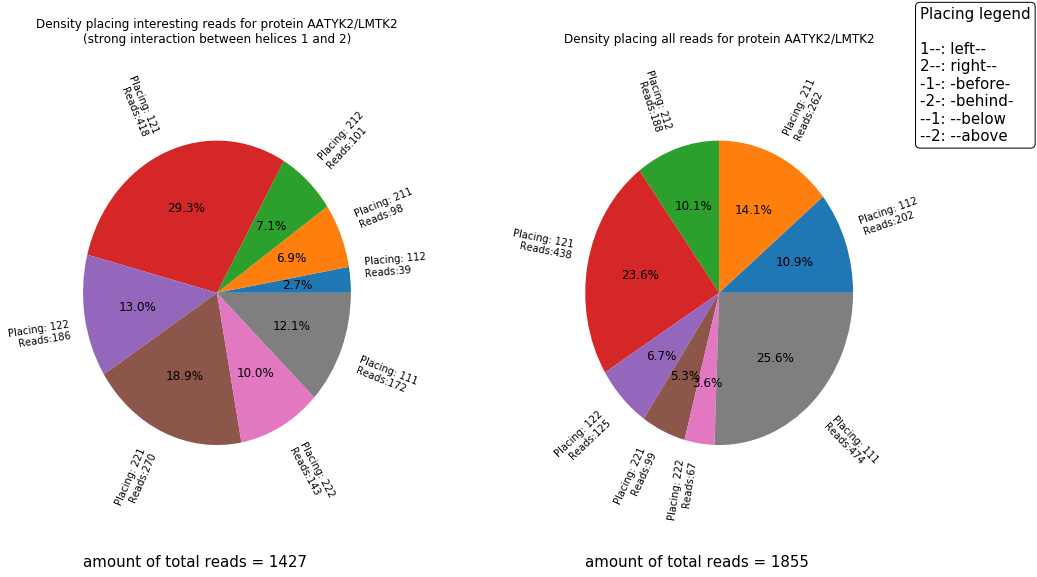

EGFR/Her1/ErbB1
run: 001
run: 002
run: 003
run: 004
run: 005
run: 007
run: 008
run: 009
run: 010
run: 011
run: 012
run: 013
run: 014
run: 015
run: 016
run: 018
run: 019
run: 020
run: 021
run: 022
run: 023
run: 024
run: 025
run: 026
run: 027
run: 028
run: 030
run: 031
run: 033
run: 034
run: 035
run: 036
run: 037
run: 038
run: 040
run: 041
run: 042
run: 043
run: 044
run: 045
run: 046
run: 048
run: 049
run: 050
run: 051
run: 052
run: 054
run: 055
run: 056
run: 057
run: 058
run: 059
run: 060
run: 061
run: 062
run: 063
run: 064
run: 065
run: 066
run: 067
run: 068
run: 069
run: 070
run: 071
run: 072
run: 073
run: 074
run: 075
run: 077
run: 078
run: 079
run: 080
run: 082
run: 083
run: 084
run: 085
run: 086
run: 087
run: 088
run: 089
run: 090
run: 091
run: 092
run: 093
run: 094
run: 095
run: 096
run: 097
run: 098
run: 099
run: 100
run: 101
run: 102
run: 104
run: 105
run: 106
run: 107
run: 109
run: 110
run: 112
run: 113
run: 114
run: 115
run: 116
run: 117
run: 118
run: 119
run: 121
run: 122
run

KeyboardInterrupt: 

In [23]:
def analyze_orientation_interaction(orientation_interaction_df):
    strengths = {"low": [], "average": [], "high": []}
    interaction_strengths = orientation_interaction_df["interaction strength"].values
    for protein, int_str in zip(orientation_interaction_df.index, interaction_strengths):
        strength = float(int_str.split()[0])
        if strength < 0.15:
            strengths["low"].append(protein)
        elif strength < 0.75:
            strengths["average"].append(protein)
        else:
            strengths["high"].append(protein)

    groups = ["low", "average", "high"]

    inter_vals = {"111": {"low": [], "average": [], "high": []},
                 "112": {"low": [], "average": [], "high": []},
                 "121": {"low": [], "average": [], "high": []},
                 "122": {"low": [], "average": [], "high": []},
                 "211": {"low": [], "average": [], "high": []},
                 "212": {"low": [], "average": [], "high": []},
                 "221": {"low": [], "average": [], "high": []},
                 "222": {"low": [], "average": [], "high": []}}

    bulk_vals = {"111": {"low": [], "average": [], "high": []},
                 "112": {"low": [], "average": [], "high": []},
                 "121": {"low": [], "average": [], "high": []},
                 "122": {"low": [], "average": [], "high": []},
                 "211": {"low": [], "average": [], "high": []},
                 "212": {"low": [], "average": [], "high": []},
                 "221": {"low": [], "average": [], "high": []},
                 "222": {"low": [], "average": [], "high": []}}

    for group in groups:
        for place, ls in zip(orientation_interaction_df.columns[:-2], 
                             orientation_interaction_df.loc[strengths[group], :].T.values[:-2]):
            for values in ls:
                inter_vals[place][group].append(values[0])
                bulk_vals[place][group].append(values[1])
    
    return strengths, inter_vals, bulk_vals, groups

def make_placings_barplot(orientation_interaction_df, groups, strengths):
    fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(15,7))
    xvals = np.arange(8)
    width = 0.35
    for index, group in enumerate(groups):
        inter_means = []
        bulk_means = []
        for place, values in orientation_interaction_df.T.iterrows():
            if len(place) == 3:
                inter = []
                bulk = []
                for protein, coords in zip(orientation_interaction_df.index, values):
                    if protein in strengths[group]:
                        inter.append(coords[0])
                        bulk.append(coords[1])
                inter_means.append(np.mean(inter))
                bulk_means.append(np.mean(bulk))
        ax[index].bar(xvals - width, inter_means, width=width, label="interesting", align="edge")
        ax[index].bar(xvals, bulk_means, width=width, label="bulk", align="edge")
        ax[index].set_title("average density in\n" \
                            "specific places for group {}".format(group), fontsize=15)

    # legend
    legend_text = ["Placing legend\n", "1--: left--", "2--: right--", 
                   "-1-: -before-", "-2-: -behind-", 
                   "--1: --below", "--2: --above"]
    bbox_props = dict(boxstyle="round", fc="white", ec="black", lw=1)
    plt.text(8.5, 1, "\n".join(legend_text), bbox=bbox_props, fontsize=15)

    ax[0].set_ylabel("average density (percentage)", fontsize=15)
    plt.suptitle("place", y=0.05, fontsize=15)
    plt.xticks(xvals, orientation_interaction_df.T.index) 
    plt.legend(loc=[1.1, 0.9])
    plt.show()

def do_one_way_ANOVA_places(places, inter_vals, bulk_vals, interesting=True):
    low = []
    average = []
    high = []
    for place in places:
        if interesting:
            group_dict = inter_vals[place]
        else:
            group_dict = bulk_vals[place]
        
        for group in group_dict.keys():
            if group == "low":
                for num in group_dict[group]:
                    low.append(num)
            elif group == "average":
                for num in group_dict[group]:
                    average.append(num)
            else:
                for num in group_dict[group]:
                    high.append(num)
    return f_oneway(low, average, high)


orientation_interaction_df = get_orientation_interaction()
strengths, inter_vals, bulk_vals, groups = analyze_orientation_interaction(orientation_interaction_df)
strengths_df = pd.DataFrame.from_dict(strengths)
make_placings_barplot(orientation_interaction_df, groups, strengths)

none = True
# for every combination with a specific number of places, calculate anova
for L in range(1, 9):
    for subset in itertools.combinations(orientation_interaction_df.columns[:-2], L):
        pval = do_one_way_ANOVA_places(list(subset), inter_vals, bulk_vals).pvalue
        if pval <= 0.05:
            none = False
            print("interesting", subset, pval)
        
        pval = do_one_way_ANOVA_places(list(subset), inter_vals, bulk_vals, False).pvalue
        if pval <= 0.05:
            none = False
            print("non-interesting", subset, pval)

if none:
    print("No significant combinations")

strengths_df